In [1]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
from IPython.display import display, HTML
from scipy.stats import spearmanr
from collections import Counter
import pandas as pd
import numpy as np
import joblib
import h5py
import os

pd.set_option("display.max_columns", None)
pd.set_option("display.expand_frame_repr", False)
pd.set_option("display.width", 2000)
pd.set_option("display.max_colwidth", None)

display(HTML("""
<style>
.dataframe td, .dataframe th {
    white-space: nowrap !important;
}
</style>
"""))


In [2]:
def get_reference_set_compounds(compounds):
    """
    Return a reference set of ChEMBL compound IDs from a compounds DataFrame.

    If the DataFrame has more than 10,000 rows, this returns a reduced reference
    set consisting of the first 5,000 and the last 5,000 `compound_chembl_id`
    values (as a list). Otherwise, it returns the full `compound_chembl_id`
    column.
    """
    if len(compounds) > 10000:
        return compounds['compound_chembl_id'][:5000].tolist() + compounds['compound_chembl_id'][-5000:].tolist()
    else:
        return compounds['compound_chembl_id']
    
def load_ecfp_subset_by_chembl_id(h5_path, chembl_id_set):
    """Load ECFP (Morgan count) fingerprints and return only requested ChEMBL IDs.

    Parameters
    ----------
    h5_path : str
        Path to the HDF5 file containing datasets "SMILES" and "X_morgan".
    chembl_id_set : set[str]
        ChEMBL IDs to keep.

    Returns
    -------
    dict[str, np.ndarray]
        Mapping {chembl_id: fingerprint (np.int8, shape (nBits,))}.
    """
    with h5py.File(h5_path, "r") as f:
        meta = f["SMILES"][:, 3].astype(str)
        fps  = f["X_morgan"][:]  # load all

    return {cid: fp for cid, fp in zip(meta, fps) if cid in chembl_id_set}

In [58]:
def get_pathogen_code(pathogen):
    return str(pathogen.split()[0][0] + pathogen.split()[1]).lower() if len(pathogen.split()) > 1 else pathogen.lower()

def condition_A(df):
    return df[ (df["dataset_type"].isin(["quantitative", "mixed"])) & 
               (df["cpds_qt"] >= 100) &
               (df["pos_qt"] >= 5) & 
               (df["ratio_qt"].between(0.01, 0.5, inclusive="both"))].copy()

def condition_B(df):
    return df[ (df["dataset_type"].isin(["qualitative", "mixed"])) & 
               (df["cpds_ql"] >= 100) &
               (df["pos_ql"] >= 5) & 
               (df["ratio_ql"].between(0.01, 0.5, inclusive="both"))].copy()

In [59]:
# Define root directory
root = "."

# List of pathogens to process
pathogens = ["Acinetobacter baumannii", "Candida albicans", "Campylobacter", "Escherichia coli", "Enterococcus faecium", "Enterobacter",
             "Helicobacter pylori", "Klebsiella pneumoniae", "Mycobacterium tuberculosis", "Neisseria gonorrhoeae", "Pseudomonas aeruginosa",
             "Plasmodium falciparum", "Staphylococcus aureus", "Schistosoma mansoni", "Streptococcus pneumoniae"]
pathogens = ["Acinetobacter baumannii", "Mycobacterium tuberculosis", "Klebsiella pneumoniae"]

# Create output directory
OUTPUT = os.path.join(root, "..", "output")

pathogen_to_datasets = {}

# For each pathogen
for pathogen in pathogens[1:2]:

    # Get pathogen code
    pathogen_code = get_pathogen_code(pathogen)
    pathogen_to_datasets[pathogen] = dict()

    # Create path to correlations
    PATH_TO_CORRELATIONS = os.path.join(OUTPUT, pathogen_code, "correlations")
    os.makedirs(PATH_TO_CORRELATIONS, exist_ok=True)

    # Get data information
    data_info = pd.read_csv(os.path.join(OUTPUT, pathogen_code, "assays_data.csv"))
    master_info = pd.read_csv(os.path.join(OUTPUT, pathogen_code, "assays_master.csv"))

    # Get compounds for pathogen
    compounds = pd.read_csv(os.path.join(OUTPUT, pathogen_code, "compound_counts.csv.gz"))
    REFERENCE_SET = get_reference_set_compounds(compounds)
    compounds = set(compounds['compound_chembl_id'])
    print(f"Loading ECFP6s for pathogen: {pathogen}. {len(compounds)} compounds")

    # Loading Morgan fingerprints
    PATH_TO_ECFPs = os.path.join(root, "..", "output", "descriptors.h5")
    ecfps = load_ecfp_subset_by_chembl_id(PATH_TO_ECFPs, compounds)

    # Prepare reference matrix of Morgan fingerprints
    X_REF = np.array([ecfps[cid] for cid in REFERENCE_SET if cid in ecfps])

Loading ECFP6s for pathogen: Mycobacterium tuberculosis. 132378 compounds


In [60]:
A = condition_A(data_info)
B = condition_B(data_info)

In [ ]:
AUROCS, STDS = [], []

# Iterate over assays A
for c, assay in A.iterrows():

    # Load varibles
    assay_id = assay.assay_id
    activity_type = assay.activity_type
    unit = assay.unit
    
    # Load data
    filename = "_".join([str(assay_id), str(activity_type), str(unit), "qt.csv.gz"])
    df = pd.read_csv(os.path.join(OUTPUT, pathogen_code, 'datasets', filename))

    # Prepare matrices
    X = np.array(df['compound_chembl_id'].map(ecfps).to_list())
    Y = np.array(df['bin'].tolist())

    print(f"Assay ID: {assay_id}, Activity type: {activity_type}, Unit: {unit}")
    print(X.shape, Y.shape)

    # Shuffle systematically
    rng = np.random.default_rng(42)   # fixed seed
    idx = rng.permutation(len(Y))
    X = X[idx]
    Y = Y[idx]

    # Initialize RF
    def init_RF():
        return RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, 
                                      min_samples_leaf=1, max_features="sqrt", n_jobs=8, random_state=42)

    # 4Fold CV
    skf = StratifiedKFold(n_splits=4)
    aurocs = []

    # For each fold
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, Y), 1):

        X_train, X_test = X[train_idx], X[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]

        # Initialize RF
        RF = init_RF()

        # fit model
        RF.fit(X_train, Y_train)

        # predicted probabilities for AUROC
        y_prob = RF.predict_proba(X_test)[:, 1]

        # compute AUROC
        auc = roc_auc_score(Y_test, y_prob)
        aurocs.append(auc)
        
        print(f"Fold {fold}: AUROC = {auc:.4f}")

    print(f"Mean AUROC: {np.mean(aurocs):.4f} ± {np.std(aurocs):.4f}")
    average_auroc = round(np.mean(aurocs), 3)
    stds = round(np.std(aurocs), 3)
    AUROCS.append(average_auroc)
    STDS.append(stds)

    # If performance is good enough
    if average_auroc > 0.7:

        # Train on full data
        RF = init_RF()
        RF.fit(X, Y)
    
        # Predict on reference set
        y_prob_ref = RF.predict_proba(X_REF)[:, 1]

        # Store predictions
        np.savez_compressed(os.path.join(PATH_TO_CORRELATIONS, filename.replace(".csv.gz", "_ref_probs.npz")), y_prob_ref=y_prob_ref)

Assay ID: CHEMBL4649948, Activity type: PERCENTEFFECT, Unit: %
(86589, 2048) (86589,)
Fold 1: AUROC = 0.6908
Fold 2: AUROC = 0.7246
Fold 3: AUROC = 0.7053
Fold 4: AUROC = 0.7144
Mean AUROC: 0.7088 ± 0.0124
Assay ID: CHEMBL4649949, Activity type: PERCENTEFFECT, Unit: %
(86575, 2048) (86575,)
Fold 1: AUROC = 0.7548
Fold 2: AUROC = 0.7258
Fold 3: AUROC = 0.7623
Fold 4: AUROC = 0.7473
Mean AUROC: 0.7475 ± 0.0136
Assay ID: CHEMBL4649971, Activity type: PERCENTEFFECT, Unit: %
(68613, 2048) (68613,)
Fold 1: AUROC = 0.7861
Fold 2: AUROC = 0.7758
Fold 3: AUROC = 0.8174
Fold 4: AUROC = 0.7731
Mean AUROC: 0.7881 ± 0.0176
Assay ID: CHEMBL4649961, Activity type: PERCENTEFFECT, Unit: %
(53165, 2048) (53165,)
Fold 1: AUROC = 0.7571
Fold 2: AUROC = 0.7471
Fold 3: AUROC = 0.7659
Fold 4: AUROC = 0.7670
Mean AUROC: 0.7593 ± 0.0080
Assay ID: CHEMBL4649949, Activity type: IC50, Unit: umol.L-1
(2468, 2048) (2468,)
Fold 1: AUROC = 0.6181
Fold 2: AUROC = 0.6042
Fold 3: AUROC = 0.6218
Fold 4: AUROC = 0.7654
Me

In [64]:
A['auroc_avg'] = AUROCS
A['auroc_std'] = STDS

In [67]:
COLS = ['assay_id', 'activity_type', 'unit', 'target_type', 'target_type_curated', 'dataset_type', 'activities', 'cpds', "pos_qt", "ratio_qt", 'auroc_avg']

In [68]:
A[COLS]

,assay_id,activity_type,unit,target_type,target_type_curated,dataset_type,activities,cpds,pos_qt,ratio_qt,auroc_avg
0,CHEMBL4649948,PERCENTEFFECT,%,UNCHECKED,ORGANISM,quantitative,93555,86589,1268.0,0.015,0.709
1,CHEMBL4649949,PERCENTEFFECT,%,UNCHECKED,ORGANISM,quantitative,101515,86575,2181.0,0.025,0.748
2,CHEMBL4649971,PERCENTEFFECT,%,ORGANISM,ORGANISM,quantitative,68619,68613,934.0,0.014,0.788
7,CHEMBL4649961,PERCENTEFFECT,%,ORGANISM,ORGANISM,quantitative,53170,53165,898.0,0.017,0.759
9,CHEMBL4649949,IC50,umol.L-1,UNCHECKED,ORGANISM,quantitative,2468,2468,90.0,0.036,0.652
10,CHEMBL4649948,IC50,umol.L-1,UNCHECKED,ORGANISM,quantitative,2466,2466,68.0,0.028,0.570
11,CHEMBL1794349,AC50,umol.L-1,SINGLE PROTEIN,SINGLE PROTEIN,mixed,2126,2121,37.0,0.017,0.868
12,CHEMBL1794426,EC50,umol.L-1,SINGLE PROTEIN,SINGLE PROTEIN,mixed,2121,2116,316.0,0.149,0.792
13,CHEMBL1794324,AC50,umol.L-1,SINGLE PROTEIN,SINGLE PROTEIN,mixed,2069,2064,118.0,0.057,0.780
18,CHEMBL2094262,INHIBITION,%,ORGANISM,ORGANISM,quantitative,399,399,66.0,0.165,0.739


In [71]:
len(A[A['auroc_avg'] > 0.7])

22

In [82]:
ASSAYS_TO_CV = A[A['auroc_avg'] > 0.7][['assay_id', 'activity_type', 'unit']].values.tolist()
ASSAYS_TO_CV = [[i[0], i[1], i[2], "qt_ref_probs.npz"] for i in ASSAYS_TO_CV]
ASSAYS_TO_CV = ["_".join(i) for i in ASSAYS_TO_CV]

In [83]:
assay_names = []
prob_vectors = []

for f in ASSAYS_TO_CV:
    path = os.path.join(PATH_TO_CORRELATIONS, f)
    if os.path.exists(path) is False:
        continue
    data = np.load(path)
    y_prob_ref = data["y_prob_ref"]

    assay_label = f.replace("_ref_probs.npz", "")
    assay_names.append(assay_label)
    prob_vectors.append(y_prob_ref)

P = np.array(prob_vectors)
corr, pvals = spearmanr(P.T)

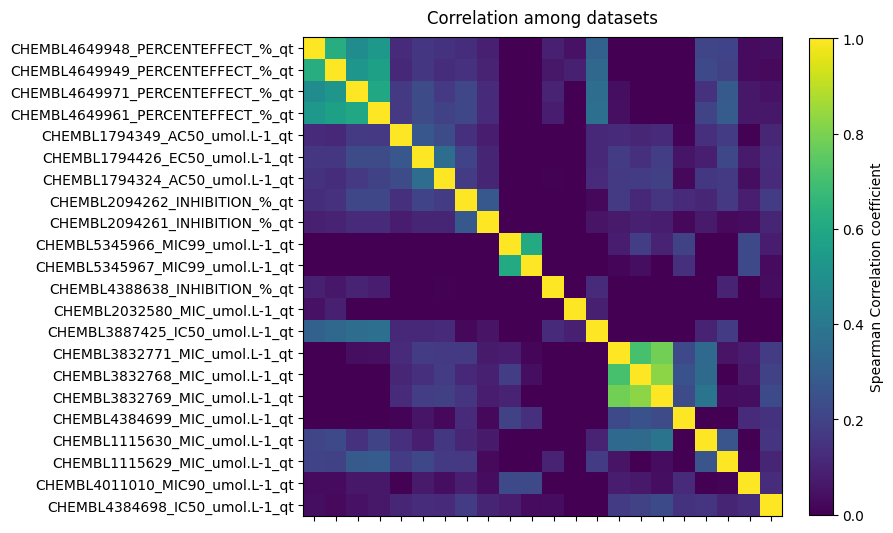

In [84]:
import matplotlib.pyplot as plt

corr_df = pd.DataFrame(corr, index=assay_names, columns=assay_names)

# --- Plot heatmap ---
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(corr_df.values, vmin=0, vmax=1)

ax.set_xticks(np.arange(len(assay_names)))
ax.set_yticks(np.arange(len(assay_names)))
ax.set_xticklabels([], rotation=90)
ax.set_yticklabels(assay_names)

ax.set_title("Correlation among datasets", pad=10, size=12)
cbar = fig.colorbar(im, ax=ax, fraction=0.045)
cbar.set_label("Spearman Correlation coefficient")

plt.tight_layout()
plt.show()

In [105]:
AUROCs_CV = []

for a in ASSAYS_TO_CV:
    
    # Load data
    filename = "_".join([str(a.split("_")[0]), str(a.split("_")[1]), str(a.split("_")[2]), "qt.csv.gz"])
    df = pd.read_csv(os.path.join(OUTPUT, pathogen_code, 'datasets', filename))

    # Prepare matrices
    X = np.array(df['compound_chembl_id'].map(ecfps).to_list())
    Y = np.array(df['bin'].tolist())

    print(f'Assay ID: {a.split("_")[0]}, Activity type: {a.split("_")[1]}, Unit: {a.split("_")[2]}')
    print(X.shape, Y.shape)

    # Shuffle systematically
    rng = np.random.default_rng(42)   # fixed seed
    idx = rng.permutation(len(Y))
    X = X[idx]
    Y = Y[idx]

    # Initialize RF
    RF = init_RF()

    print("Fitting model on full data...")

    # Fit model
    RF.fit(X, Y)

    print("Predicting on the rest of datasets...")

    AUROCs_MODEL = []

    for dataset in ASSAYS_TO_CV:

        # Load data
        filename = "_".join([str(dataset.split("_")[0]), str(dataset.split("_")[1]), str(dataset.split("_")[2]), "qt.csv.gz"])
        df = pd.read_csv(os.path.join(OUTPUT, pathogen_code, 'datasets', filename))

        # Prepare matrices
        X_test = np.array(df['compound_chembl_id'].map(ecfps).to_list())
        Y_test = np.array(df['bin'].tolist())

        # Predict on test
        y_pred = RF.predict_proba(X_test)[:, 1]
        auroc = roc_auc_score(Y_test, y_pred)

        AUROCs_MODEL.append(auroc)

    AUROCs_CV.append(AUROCs_MODEL)

Assay ID: CHEMBL4649948, Activity type: PERCENTEFFECT, Unit: %
(86589, 2048) (86589,)
Fitting model on full data...
Predicting on the rest of datasets...
Assay ID: CHEMBL4649949, Activity type: PERCENTEFFECT, Unit: %
(86575, 2048) (86575,)
Fitting model on full data...
Predicting on the rest of datasets...
Assay ID: CHEMBL4649971, Activity type: PERCENTEFFECT, Unit: %
(68613, 2048) (68613,)
Fitting model on full data...
Predicting on the rest of datasets...
Assay ID: CHEMBL4649961, Activity type: PERCENTEFFECT, Unit: %
(53165, 2048) (53165,)
Fitting model on full data...
Predicting on the rest of datasets...
Assay ID: CHEMBL1794349, Activity type: AC50, Unit: umol.L-1
(2121, 2048) (2121,)
Fitting model on full data...
Predicting on the rest of datasets...
Assay ID: CHEMBL1794426, Activity type: EC50, Unit: umol.L-1
(2116, 2048) (2116,)
Fitting model on full data...
Predicting on the rest of datasets...
Assay ID: CHEMBL1794324, Activity type: AC50, Unit: umol.L-1
(2064, 2048) (2064,)
Fi

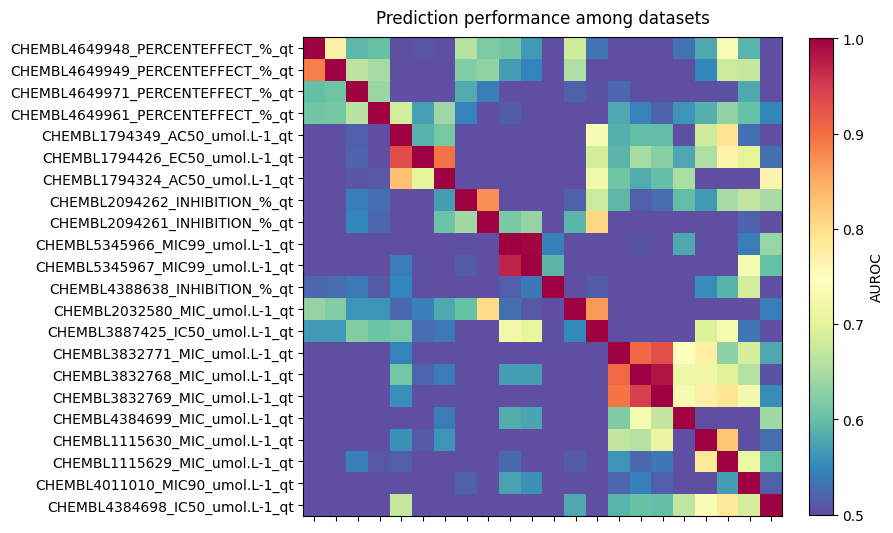

In [123]:
# --- Plot heatmap ---
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(AUROCs_CV, vmin=0.5, vmax=1, cmap='Spectral_r')

ax.set_xticks(np.arange(len(ASSAYS_TO_CV)))
ax.set_yticks(np.arange(len(ASSAYS_TO_CV)))
ax.set_xticklabels([], rotation=90)
ax.set_yticklabels([i.replace("_ref_probs.npz", "") for i in ASSAYS_TO_CV])

ax.set_title("Prediction performance among datasets", pad=10, size=12)
cbar = fig.colorbar(im, ax=ax, fraction=0.045)
cbar.set_label("AUROC")

plt.tight_layout()
plt.show()